<a href="https://colab.research.google.com/github/ssook1222/1Day-1Algo/blob/master/model/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

### 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 의료기관 데이터

In [28]:
csv_path_medical = '/content/drive/MyDrive/town_cc_big_data/data/행정동_강원도_춘천시_의료기관약국_20220805.csv'

In [29]:
df_medical_raw = pd.read_csv(csv_path_medical)
address_data = df_medical_raw['행정동']
kind_data = df_medical_raw['종류']

df_medical = pd.DataFrame({'종류': kind_data, '행정동': address_data})
df_medical = df_medical.groupby('행정동').count().rename(columns={'종류': '병원 수'})
df_medical = df_medical.sort_values('병원 수', ascending=True)

#### 독거노인 수 데이터

In [30]:
csv_path_old = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_독거노인현황_20220620.csv'

In [31]:
df_old_raw = pd.read_csv(csv_path_old, encoding='euc-kr')
df_old = df_old_raw.groupby('행정동명')['인구수'].sum().reset_index()
df_old = df_old.sort_values('인구수', ascending = False)

#### 정신건강 관련 기관 및 병원 데이터

In [32]:
csv_path_mental1 = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_정신건강센터 현황_20220822.csv'
csv_path_mental2 = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_정신건강의학과 현황_20220822.csv'

In [33]:
df_old_mental1 = pd.read_csv(csv_path_mental1)
df_old_mental2 = pd.read_csv(csv_path_mental2)

df_old_mental1 = df_old_mental1[['기관명', '행정동']]
df_old_mental2 = df_old_mental2[['상호명', '행정동']]

df_mental = pd.concat([df_old_mental1, df_old_mental2.rename(columns={'상호명': '기관명'})], ignore_index=True)
df_mental = df_mental.groupby('행정동')['기관명'].count().reset_index()
df_mental = df_mental.sort_values('기관명', ascending = False)

#### 1인 가구 수

In [34]:
csv_path_one_person = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_읍면동별 1인 가구수_20220816.csv'

In [35]:
df_one_person = pd.read_csv(csv_path_one_person, encoding='euc-kr')
df_one_person = df_one_person.groupby('행정동')['1인가구수'].sum().reset_index()
df_one_person = df_one_person.sort_values('1인가구수', ascending=False)

#### 행정동별 초등학교 위치 수

In [36]:
csv_path_elm = '/content/drive/MyDrive/town_cc_big_data/data/강원도교육청_춘천시초등학교_통학구역_20220731.csv'

In [37]:
df_elm = pd.read_csv(csv_path_elm, encoding='euc-kr')
df_elm = df_elm.groupby('행정동명')['관할학교명'].count().reset_index()
df_elm.columns = ['행정동명', '초등학교 수']
df_elm = df_elm.sort_values('초등학교 수', ascending=False)

#### 아동급식카드 가맹점 수

In [38]:
csv_path_store = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_아동급식카드 가맹점_20220608.csv'

In [39]:
df_store = pd.read_csv(csv_path_store, encoding='euc-kr')
df_store = df_store[['소재지지번주소', '가맹점명']]
for index, row in df_store.iterrows():
    address = row['소재지지번주소']
    split_data = address.split()
    if len(split_data) >= 3:
        new_data = split_data[2]
        df_store.at[index, '소재지지번주소'] = new_data

df_store = df_store.groupby('소재지지번주소').size().reset_index(name='가맹점수')
df_store = df_store.sort_values('가맹점수', ascending=False)
df_store = df_store.rename(columns={'가맹점수': '가맹점 수'})

### [참고] 데이터 목록
---
df_medical : 의료기관 데이터     
df_old : 독거 노인 수 데이터    
df_mental : 정신건강 관련 기관 총합 데이터        
df_one_person : 1인 가구 수 데이터    
df_elm : 행정동별 초등학교 위치 수 데이터     
df_store : 아동급식카드 가맹점 수 데이터

### 의사결정 나무 생성

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [41]:
df_store

,소재지지번주소,가맹점 수
38,퇴계동,580
40,후평동,545
15,석사동,534
39,효자동,525
6,동내면,273
7,동면,253
28,온의동,215
30,우두동,156
5,남산면,148
24,신북읍,111


In [42]:
df_combined = df_medical.merge(df_old, left_on='행정동', right_on='행정동명', how='outer')
df_combined = df_combined.merge(df_mental, left_on='행정동명', right_on='행정동', how='outer')
df_combined = df_combined.merge(df_one_person, on='행정동', how='outer')
df_combined = df_combined.merge(df_elm, on='행정동명', how='outer')
df_combined = df_combined.merge(df_store, left_on='행정동명', right_on='소재지지번주소', how='outer')

df_combined = df_combined.fillna('0')

In [43]:
X = df_combined[['병원 수', '인구수', '기관명', '1인가구수', '가맹점 수']]
y = df_combined['행정동']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [45]:
decision_tree = DecisionTreeClassifier()

In [46]:
print(y_train.unique())

['0' '효자1동' '교동' '동면' '후평2동' '신사우동' '남산면' '신북읍' '후평1동' '후평동' '효자2동' '석사동'
 '약사명동' '조운동' '동내면' '퇴계동' '북산면' '효자3동' '근화동' '사북면' '강남동' '온의동' '효자동' '봉의동']


In [47]:
decision_tree.fit(X_train, y_train_encoded)

DecisionTreeClassifier()

In [48]:
y_pred_encoded = decision_tree.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [24]:
y_pred

array(['북산면', '북산면', '0', '0', '0', '0', '근화동', '북산면', '0', '0', '후평2동',
       '0', '0', '후평1동', '0', '0', '봉의동', '0', '0', '0'], dtype=object)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.65

근화동이랑 북산명, 후평동, 봉의동 이렇게 4개의 행정동이 나옴!

### 의사결정나무 시각화

In [26]:
!pip install graphviz
!pip install pydotplus

In [57]:
!pip install --upgrade graphviz
!pip install --upgrade pydotplus

In [60]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from graphviz import Graph

In [66]:
!apt-get -qq -y install fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 설치 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


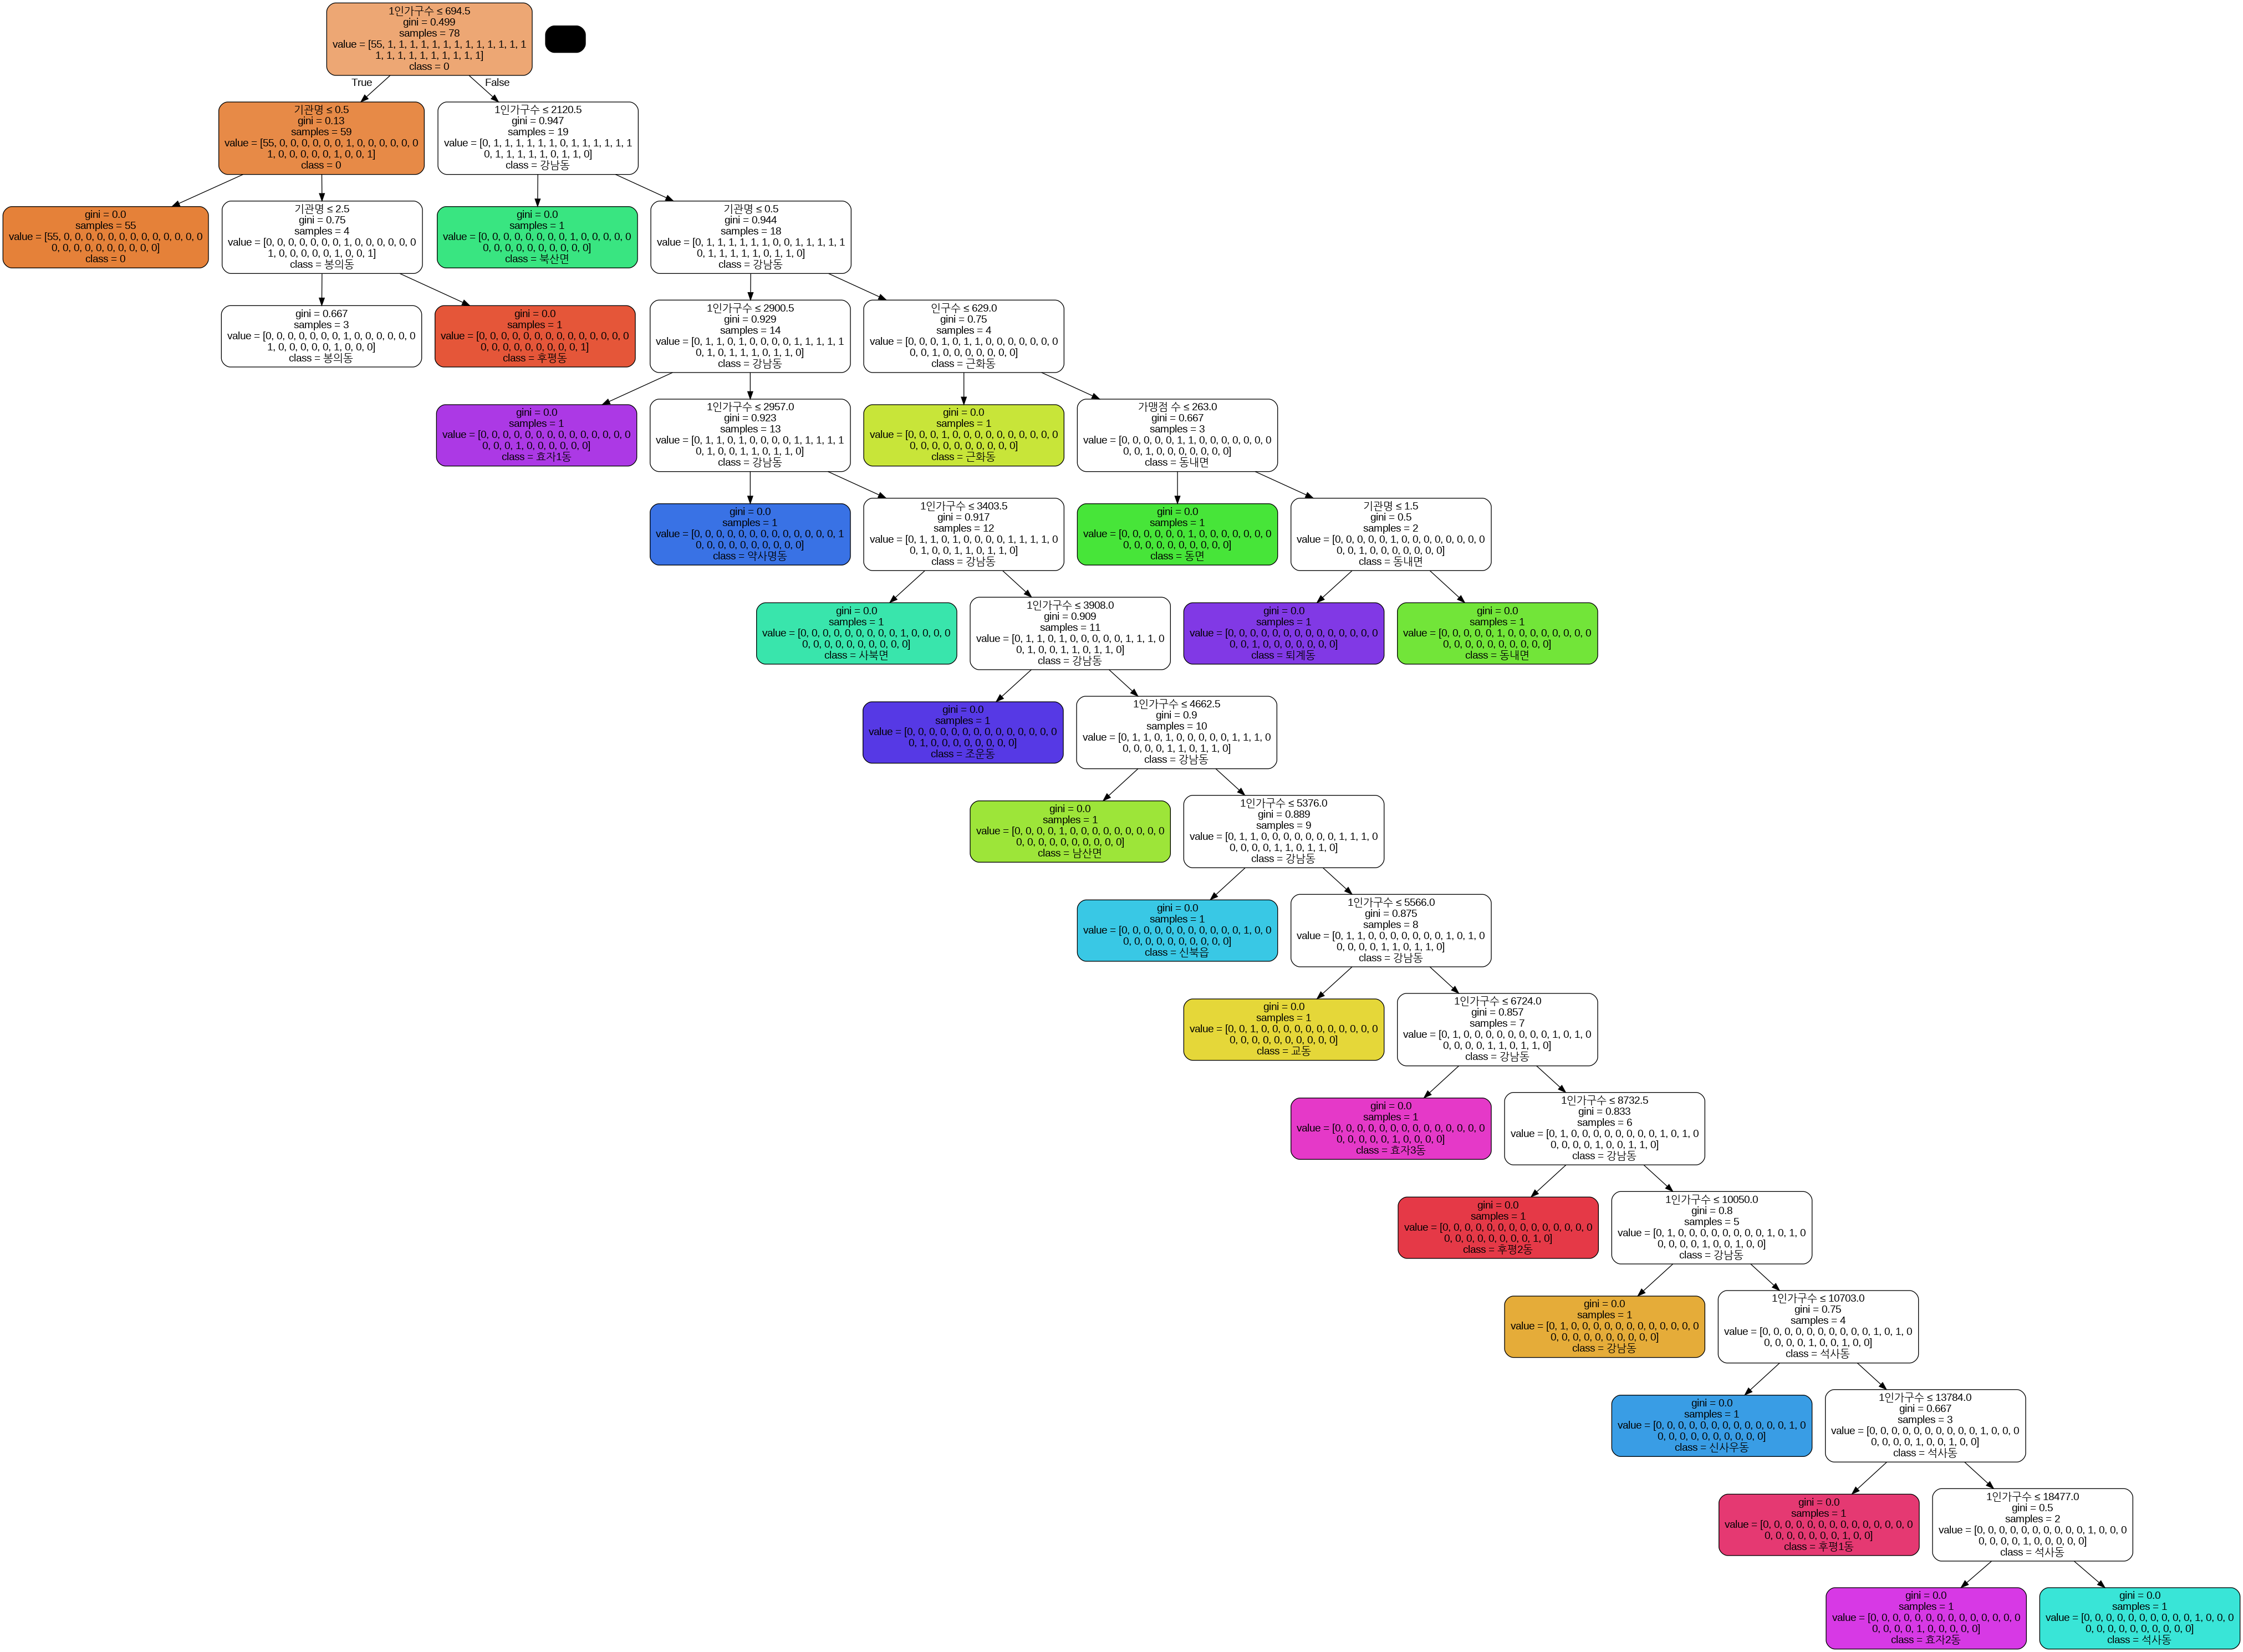

In [67]:
dot_data = export_graphviz(decision_tree, out_file=None, feature_names=X.columns, class_names=label_encoder.classes_, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())